# Cloud Segmentation
- **Source**
    - Link: https://www.kaggle.com/c/understanding_cloud_organization/data
- **Clouds**
    - Fish
    - Flower
    - Gravel
    - Sugar

## Introduction
1. **Load Data**
    - Prepare Image_IDs
2. **Data Visualization**
3. **Functions for Model**
    - Customized Data Generator Function
    - Training Validation Testing Split Function
    - Customized Metrics
4. **Model**
    - Build DenseNet
    - Early Stop and Save Model Functions
5. **Evaluate Model**

In [231]:
import os
import cv2
import time
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load Data: Prepare Image_IDs

In [246]:
df = pd.read_csv('dataset/train.csv')
df.head(8)

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...
5  002be4f.jpg_Flower  1339279 519 1340679 519 1342079 519 1343479 51...
6  002be4f.jpg_Gravel                                                NaN
7   002be4f.jpg_Sugar  67495 350 68895 350 70295 350 71695 350 73095 ...

In [244]:
df['Image_IDs'] = [f.split('.')[0] for f in df['Image_Label']]
df['Class'] = [f.split('_')[-1] for f in df['Image_Label']]
df = df.dropna()
df.head(5)

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   
5  002be4f.jpg_Flower  1339279 519 1340679 519 1342079 519 1343479 51...   
7   002be4f.jpg_Sugar  67495 350 68895 350 70295 350 71695 350 73095 ...   

  Image_IDs   Class  
0   0011165    Fish  
1   0011165  Flower  
4   002be4f    Fish  
5   002be4f  Flower  
7   002be4f   Sugar

In [4]:
df_new = df.groupby('Image_IDs')['Class'].agg(set).reset_index()
df_new.head(2)

Image_IDs                  Class
0   0011165         {Flower, Fish}
1   002be4f  {Sugar, Flower, Fish}

In [243]:
classes = ['Fish', 'Flower', 'Gravel', 'Sugar']
for class_name in classes:
    df_new[class_name] = df_new['Class'].map(lambda x: 1 if class_name in x else 0)
df_new.head(5)

Image_IDs                  Class  Fish  Flower  Gravel  Sugar
0   0011165         {Flower, Fish}     1       1       0      0
1   002be4f  {Sugar, Flower, Fish}     1       1       0      1
2   0031ae9  {Sugar, Flower, Fish}     1       1       0      1
3   0035239       {Gravel, Flower}     0       1       1      0
4   003994e  {Sugar, Gravel, Fish}     1       0       1      1

Text(0.5, 1, 'Relationships Between Each 2 Clouds')

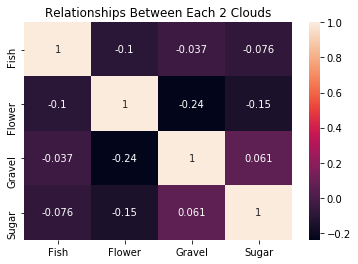

In [235]:
sns.heatmap(df_new[['Fish', 'Flower', 'Gravel', 'Sugar']].corr(), annot = True)
plt.title('Relationships Between Each 2 Clouds')

Text(0.5, 1.0, 'Cloud Forms in the Dataset')

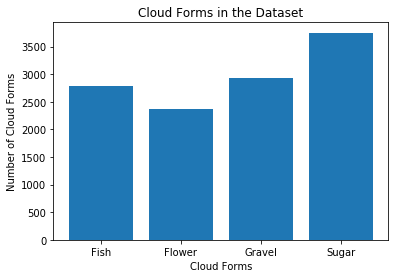

In [242]:
plt.bar(x = ['Fish', 'Flower', 'Gravel', 'Sugar'], height = df_new[['Fish', 'Flower', 'Gravel', 'Sugar']].sum(axis = 0))
plt.ylabel('Number of Cloud Forms')
plt.xlabel('Cloud Forms')
plt.title('Cloud Forms in the Dataset')

In [6]:
Image_IDs = df_new['Image_IDs'].unique().tolist()
print(f'Number of images: {len(Image_IDs)}')

Number of images: 5546


## 2. Data Visualization
- **The order in the mask array:** Fish, Flower, Gravel, Sugar

In [7]:
image_dir = 'dataset/train_images'
mask_dir  = 'dataset/train_masks_numpy_array'
height = 320
width  = 512

In [206]:
def plot_certain_clouds(cloud='Fish', dataframe=df_new):
    clouds = np.array(['Fish', 'Flower', 'Gravel', 'Sugar'])
    k = np.where(clouds == cloud)[0]
    n = 4 # plot 4 images
    df_select = dataframe[dataframe[cloud] == 1].reset_index(drop = True)
    idx = np.arange(len(df_select))
    np.random.shuffle(idx)
    select_ids = df_select.iloc[idx[0:4]]['Image_IDs'].values
    # plot
    plt.figure(figsize = (20, 13))
    for i in range(n):
        img = plt.imread(image_dir + '/' + select_ids[i] + '.jpg')
        img = cv2.resize(img, (width, height))
        msk = np.load(mask_dir + '/' + select_ids[i] + '.npy')[:, :, k]
        msk = np.concatenate([msk]*3, -1)
        msk_on_img = img*msk
        plt.subplot(2, 2, i + 1)
        plt.imshow(msk_on_img.astype(np.uint8))
        plt.title(select_ids[i], fontsize = 15)
        plt.axis('off')
    plt.suptitle(cloud, fontsize = 25)
    plt.show()

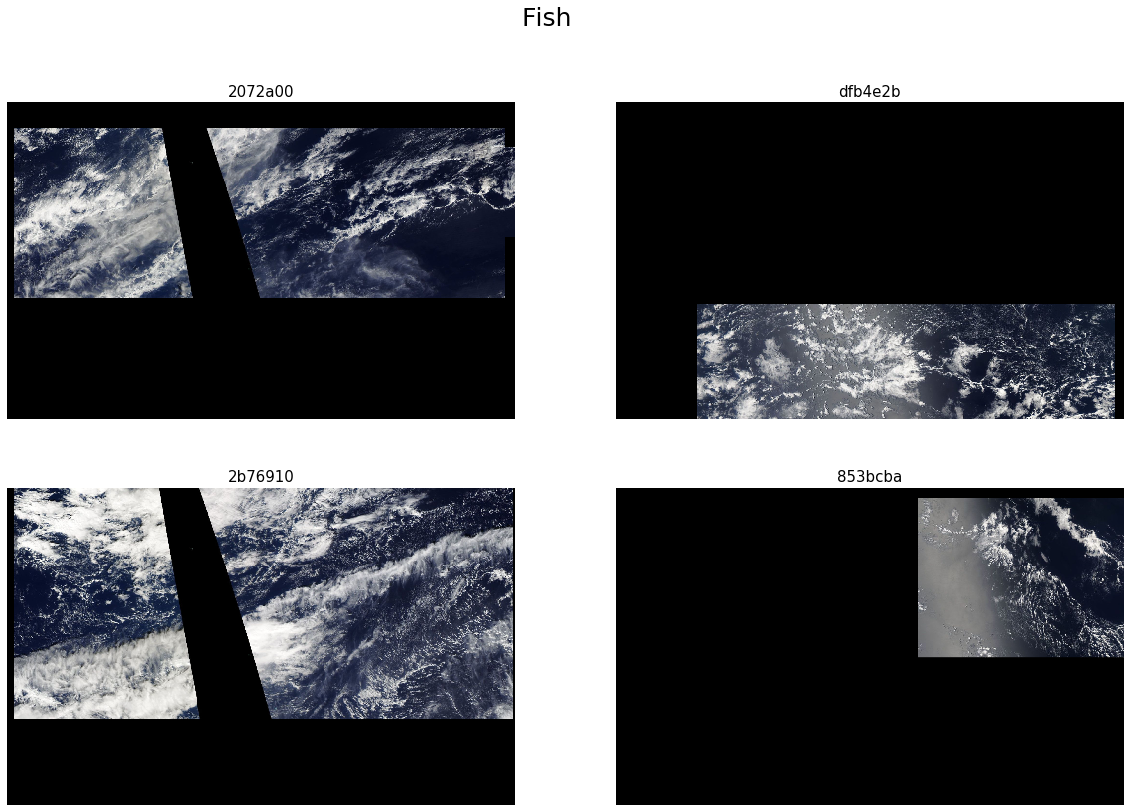

In [230]:
plot_certain_clouds('Fish')

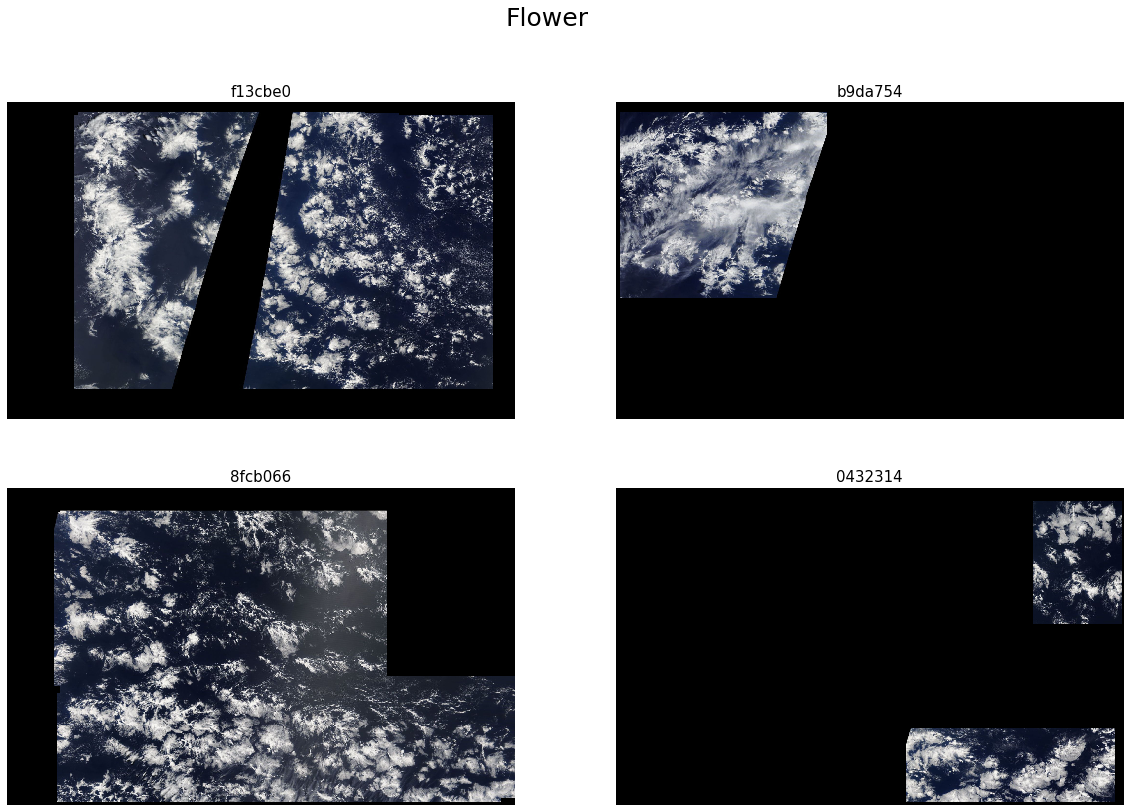

In [220]:
plot_certain_clouds('Flower')

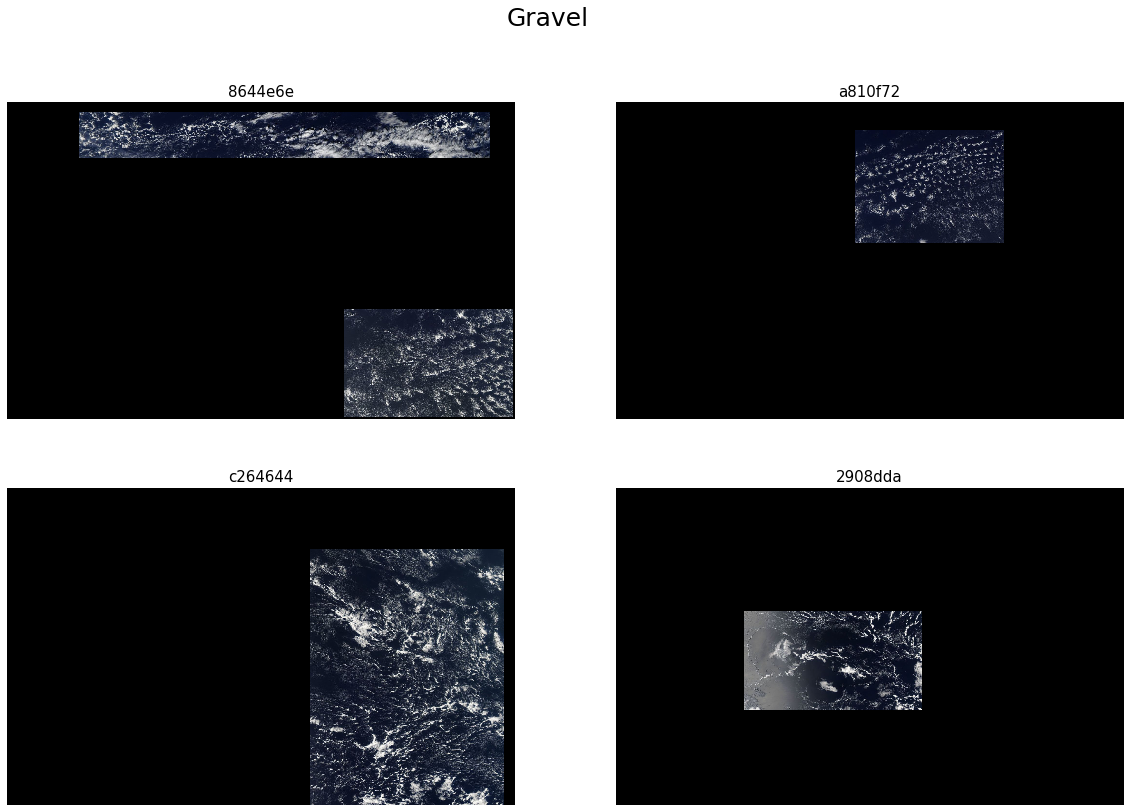

In [218]:
plot_certain_clouds('Gravel')

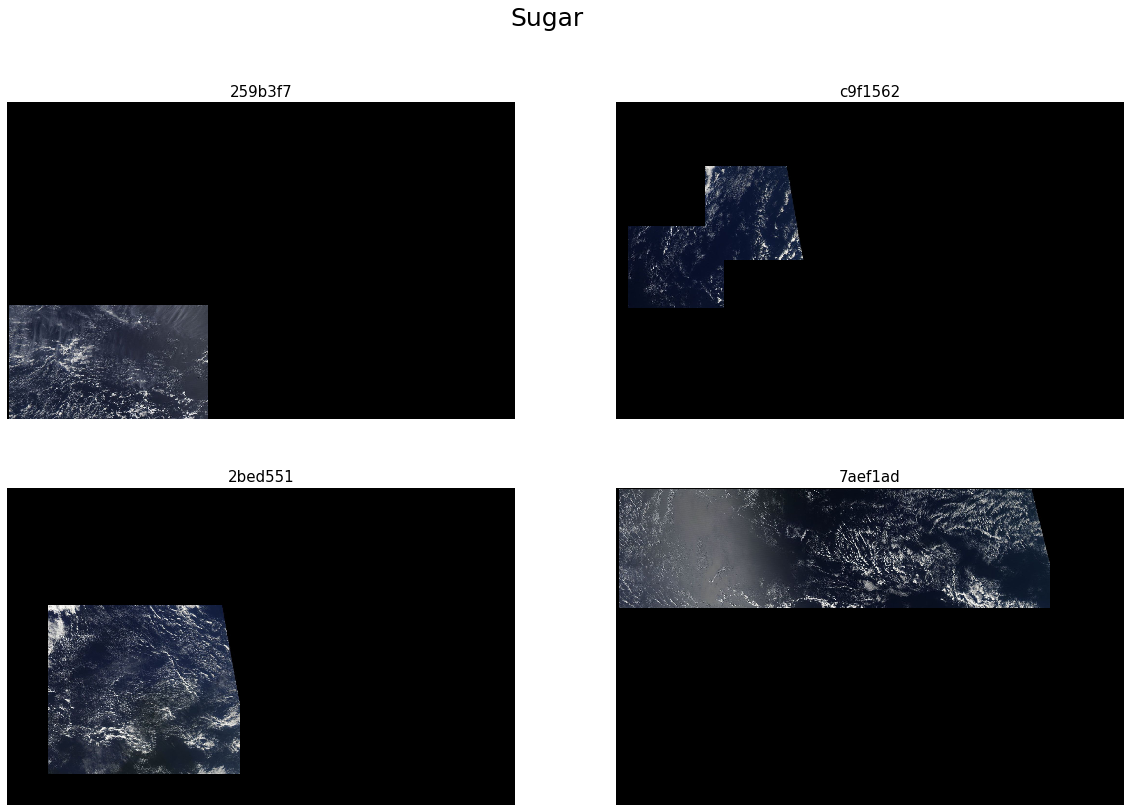

In [219]:
plot_certain_clouds('Sugar')

In [269]:
def plot_image_and_masks(index=0, dataframe=df_new):
    clouds = np.array(['Fish', 'Flower', 'Gravel', 'Sugar'])
    data_id = dataframe['Image_IDs'].unique()[index]
    plt.figure(figsize = (20, 10))
#     plt.subplot(2, 3, 1)
    img = plt.imread(image_dir + '/' + data_id + '.jpg')
    img = cv2.resize(img, (width, height))
    plt.imshow(img); plt.title('Original Image', fontsize = 20)
    plt.axis('off')
    msk = np.load(mask_dir + '/' + data_id + '.npy')
    plt.show()
    # plot 4 masks
    j = 1
    for i in range(4):
#         plt.subplot(2, 3, j + 1)
        plt.imshow(msk[:, :, i])
#         plt.title('Mask: '+clouds[i], fontsize = 20)
        plt.axis('off')
        j += 1
        plt.show()
    plt.tight_layout()
    plt.show()

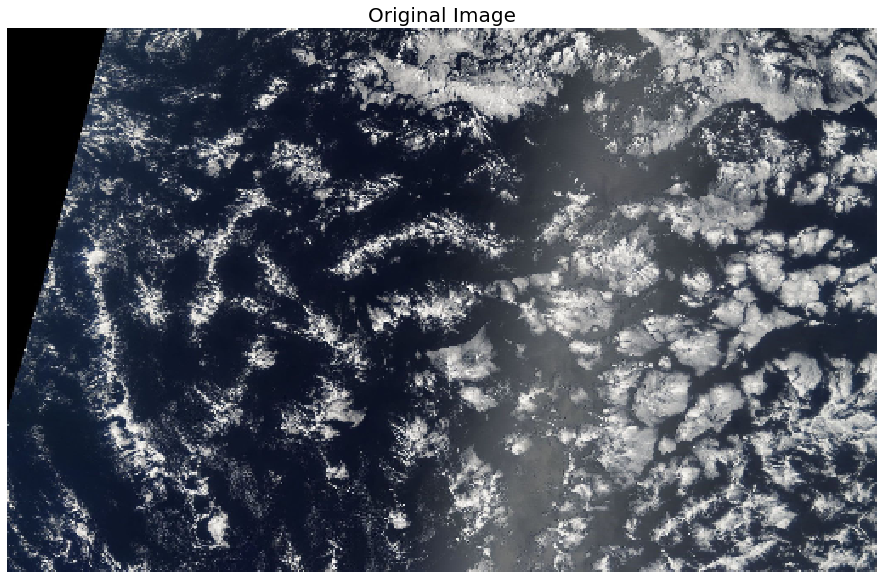

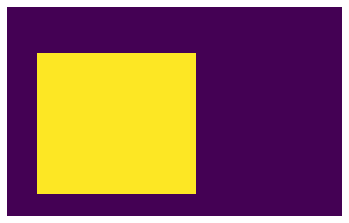

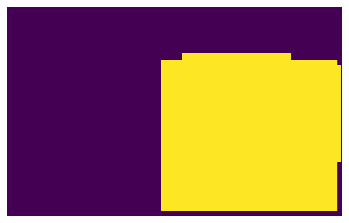

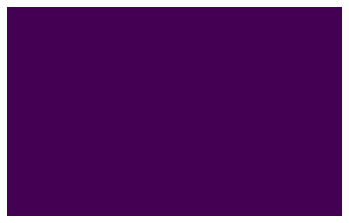

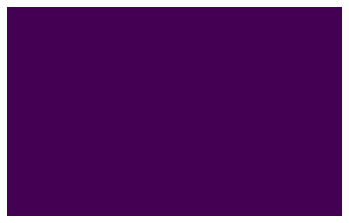

<Figure size 432x288 with 0 Axes>

In [270]:
plot_image_and_masks()

## 3. Functions for Model

In [13]:
import tensorflow.keras as keras
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion

In [14]:
class CloudDataGenerator(keras.utils.Sequence):
    
    def __init__(self, Image_IDs, batch_size=32,
                 dim=(height, width), n_channels=3,
                 data_augmentation=None, shuffle=True):
        self.Image_IDs  = Image_IDs
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.data_augmentation = data_augmentation
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.Image_IDs) // self.batch_size
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find Image IDs
        Image_IDs_temp = [self.Image_IDs[k] for k in indexes]
        
        # Generate data
        X, M = self.__data_generation(Image_IDs_temp)
        
        return X, M
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.Image_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, Image_IDs_temp):
        'Generates data containing batch_size samples'
        # X: (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        M = np.empty((self.batch_size, *self.dim, self.n_channels+1))
        
        # Generate data
        for i, ID in enumerate(Image_IDs_temp):
            # Store input images
            image = plt.imread(image_dir + '/' + ID + '.jpg')
            X[i,] = cv2.resize(image, (self.dim[1], self.dim[0]))
            X[i,] = X[i,]/255.0
            # Store target masks
            # In order: Clouds = ['Fish', 'Flower', 'Gravel', 'Sugar']
            M[i,] = np.load(mask_dir + '/' + ID + '.npy')
        return X, M

In [15]:
def train_vailid_test_split(ids):
    ''' Function to split dataset
            - train dataset: 0.8
            - valid dataset: 0.1
            - test  dataset: 0.1
        Inputs:
            - ids: entire ids
        Return:
            - train_ids
            - valid_ids
            - test_ids
            - example: 'b66217b' without '.jpg' or '.npy'
    '''
    train_size = 0.8
    # np.random.shuffle(ids)
    
    train_samples = int(len(ids) * train_size)
    valid_samples = int(len(ids) * 0.1)
    
    train_IDs = ids[0:train_samples]
    rest_IDs = ids[train_samples:]
    valid_IDs = rest_IDs[0:valid_samples]
    test_IDs = rest_IDs[valid_samples:]
    return train_IDs, valid_IDs, test_IDs

In [16]:
trn_IDs, val_IDs, new_IDs = train_vailid_test_split(Image_IDs)
len(trn_IDs) + len(val_IDs) + len(new_IDs) == len(Image_IDs)

True

In [17]:
print(f'training samples:\t{len(trn_IDs)}')
print(f'validation samples:\t{len(val_IDs)}')
print(f'testing samples:\t{len(new_IDs)}')

training samples:	4436
validation samples:	554
testing samples:	556


In [18]:
trn_datagen = CloudDataGenerator(trn_IDs, shuffle = True)
val_datagen = CloudDataGenerator(val_IDs, shuffle = False)
new_datagen = CloudDataGenerator(new_IDs, shuffle = False)

In [19]:
Xs, Ms = trn_datagen.__getitem__(0)
Xs.shape, Ms.shape

((32, 320, 512, 3), (32, 320, 512, 4))

In [20]:
def plot_datagen(Xs, Ms):
    n = 4
    idx = np.arange(Xs.shape[0])
    np.random.shuffle(idx)
    # plot
    plt.figure(figsize = (20, 13))
    for i in range(n):
        x = Xs[idx[i]]
        m = Ms[idx[i]]
        m = m[:,:,0]+m[:,:,1]+m[:,:,2]+m[:,:,3]
        m[m >= 1.] = 1.
        m = np.expand_dims(m, -1)
        m = np.concatenate([m]*3, -1)
        msk_on_img = x*m
        plt.subplot(2, 2, i + 1)
        plt.imshow(msk_on_img)
    plt.suptitle('Mask on Image', fontsize = 25)
    plt.show()

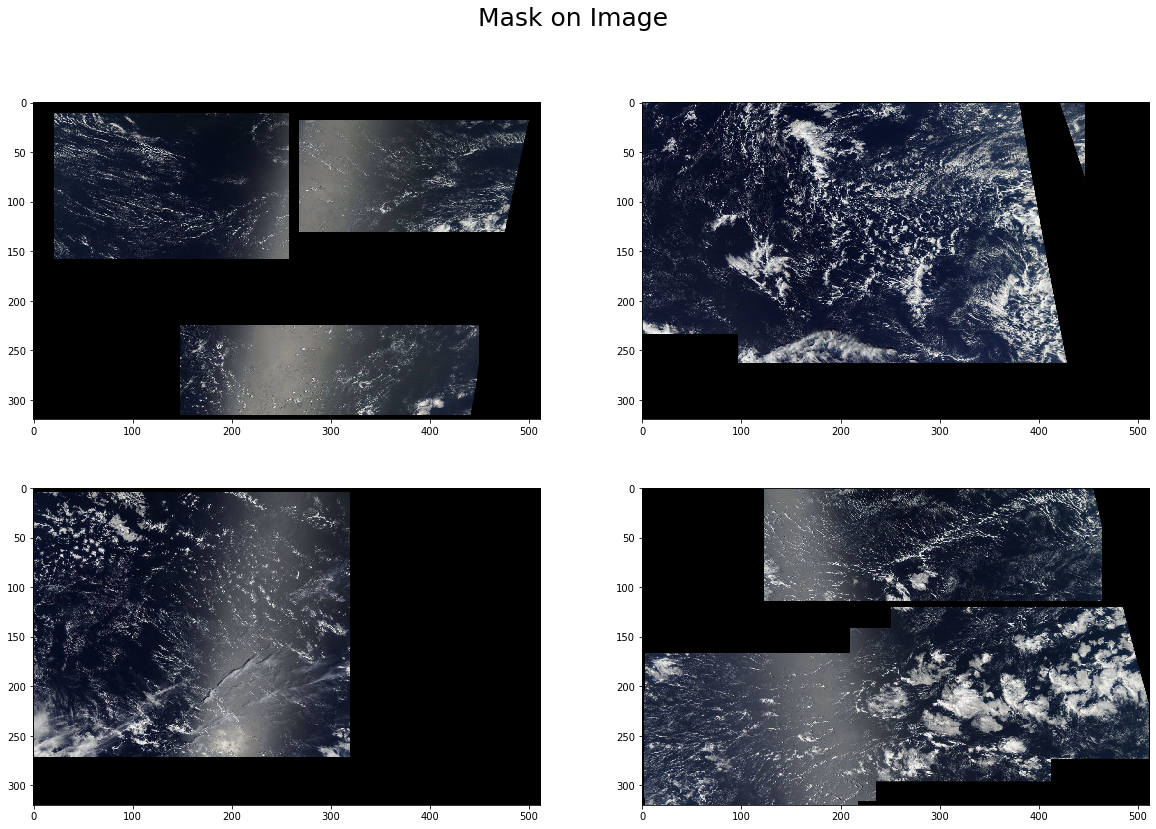

In [21]:
plot_datagen(Xs, Ms)

## 4. Model

In [22]:
import keras.layers as layers
from keras.layers import Activation
from keras.models import Model
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [29]:
filters = 32
def conv_dense_block_v1(tensor_in, filters=filters):
    # conv layer 1
    c1 = layers.Conv2D(filters, 3, strides = 1, padding = 'same')(tensor_in)
    b1 = layers.BatchNormalization()(c1)
    a1 = Activation('relu')(b1)
    # conv layer 2
    c2 = layers.Conv2D(filters, 3, strides = 1, padding = 'same')(a1)
    b2 = layers.BatchNormalization()(c2)
    a2 = Activation('relu')(b2)
    cat_a1_a2 = layers.concatenate([a1, a2])
    # conv layer 3
    c3 = layers.Conv2D(filters, 3, strides = 1, padding = 'same')(cat_a1_a2)
    b3 = layers.BatchNormalization()(c3)
    a3 = Activation('relu')(b3)
    # tensor out
    tensor_out = layers.concatenate([a3, cat_a1_a2])
    return tensor_out
def transition_layer(tensor_in, filters=filters):
    # 1 by 1 conv layer
    conv = layers.Conv2D(filters, 1, strides = 1, padding = 'same')(tensor_in)
    batchnorm = layers.BatchNormalization()(conv)
    act = Activation('relu')(batchnorm)
    maxpool = layers.MaxPool2D(2, 2)(act)
    return maxpool
def dconv_dense_block_v1(tensor_in, filters=filters):
    # dconv layer
    dconv = layers.Conv2D(filters, 3, strides = 1, padding = 'same')(tensor_in)
    batchnorm = layers.BatchNormalization()(dconv)
    act = Activation('relu')(batchnorm)
    upsample = layers.UpSampling2D(2)(act)
    return upsample

In [30]:
def IoU(y_true, y_pred):
    
    y_tp = y_pred * y_true
    tp = K.sum(y_tp[y_tp > 0.5])
    # union
    y_union = y_pred + y_true
    tp_fn_fp = K.sum(y_union[y_union >= 0.5])
    
    return tp/tp_fn_fp

In [31]:
input_layer = layers.Input(shape = (height, width, 3))

'''Conv Dense Block'''
# Dense Block 1
cdb_1 = conv_dense_block_v1(input_layer)
p_1 = transition_layer(cdb_1)
# p_1: 160x256
# Dense Block 2
cdb_2 = conv_dense_block_v1(p_1)
p_2 = transition_layer(cdb_2)
# p_2: 80x128
# Dense Block 3
cdb_3 = conv_dense_block_v1(p_2)
p_3 = transition_layer(cdb_3)
# p_3: 40x64
# Dense Block 4
cdb_4 = conv_dense_block_v1(p_3)
p_4 = transition_layer(cdb_4)
# p_4: 20x32
# Dense Block 5
cdb_5 = conv_dense_block_v1(p_4)
p_5 = transition_layer(cdb_5)
# p_5: 10x16
# Dense Block 6
cdb_6 = conv_dense_block_v1(p_5)
p_6 = transition_layer(cdb_6)
# p_6: 5x8

'''Deconv Dense Block'''
# Deconv Dense 1
dcdb_1 = dconv_dense_block_v1(p_6)
concate_1 = layers.concatenate([dcdb_1, p_5])
# # Deconv Dense 2
dcdb_2 = dconv_dense_block_v1(concate_1)
concate_2 = layers.concatenate([dcdb_2, p_4])
# Deconv Dense 3
dcdb_3 = dconv_dense_block_v1(concate_2)
concate_3 = layers.concatenate([dcdb_3, p_3])
# Deconv Dense 4
dcdb_4 = dconv_dense_block_v1(concate_3)
concate_4 = layers.concatenate([dcdb_4, p_2])
# Deconv Dense 5
dcdb_5 = dconv_dense_block_v1(concate_4)
concate_5 = layers.concatenate([dcdb_5, p_1])
# Deconv Dense 6
dcdb_6 = dconv_dense_block_v1(concate_5)
# '''Output Layer'''
output_layer = layers.Conv2D(4, 1, strides= 1, padding = 'same', activation = 'sigmoid')(dcdb_6)

In [1]:
model = Model(inputs = input_layer, outputs = output_layer)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [IoU])
model.summary()

In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_IoU', mode='max', verbose=1, save_best_only=True)

In [40]:
history = model.fit(trn_datagen, epochs = 12, validation_data = val_datagen, callbacks = [es, mc])

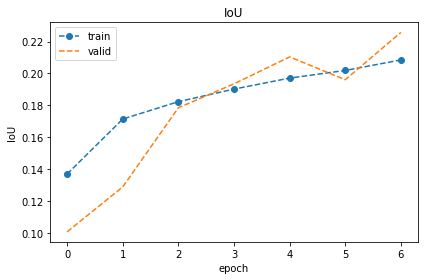

In [39]:
iou1 = [0.1369, 0.1714, 0.1823, 0.1902, 0.1971, 0.2019, 0.2085]
iou2 = [0.1006, 0.1288, 0.1785, 0.1935, 0.2104, 0.1961, 0.2258]
plt.plot(iou1, '--o', label = 'train')
plt.plot(iou2, '--', label = 'valid')
plt.xlabel('epoch'); plt.ylabel('IoU')
plt.legend()
plt.title('IoU'); plt.tight_layout()

## Load Best Model

In [41]:
from keras.models import load_model

In [47]:
dependencies = {'IoU': IoU}
saved_model = load_model('best_model.h5', custom_objects = dependencies)

In [52]:
y_proba = saved_model.predict(Xs)

In [74]:
def plot_true_pred_raw(Xs, Ys, model = saved_model):
    idx = np.random.choice(np.arange(Xs.shape[0]))
    y_proba = model.predict(np.expand_dims(Xs[idx], 0)).squeeze()
    plt.figure(figsize = (5, 5))
    plt.imshow(Xs[idx]); plt.title('Ori Img')
    
    plt.figure(figsize = (10, 10))
    j = 1
    for i in range(4):
        plt.subplot(4, 2, j)
        plt.imshow(Ys[idx][:, :, i]); j += 1
        plt.subplot(4, 2, j)
        plt.imshow(y_proba[:, :, i]); j += 1

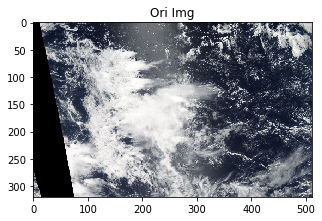

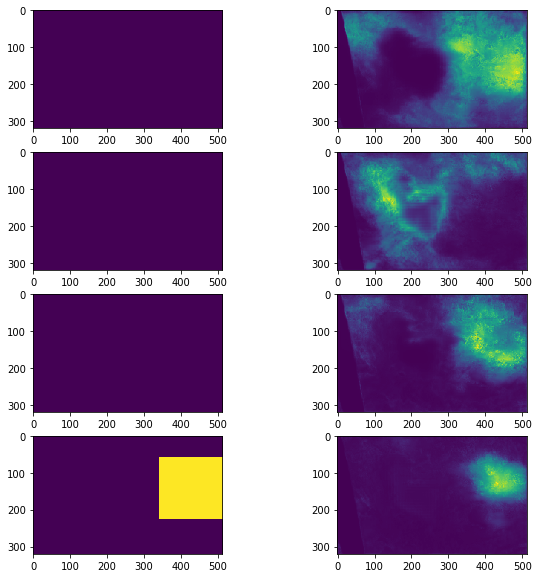

In [86]:
plot_true_pred_raw(Xs, Ms)

In [93]:
Xs.shape

(32, 320, 512, 3)

## Threshold Optimization

In [94]:
def batch_data_generation(Image_IDs_temp):
    batch_size = len(Image_IDs_temp)
    'Generates data containing batch_size samples'
    # X: (n_samples, *dim, n_channels)
    X = np.empty((batch_size, 320, 512, 3))
    M = np.empty((batch_size, 320, 512, 4))
        
    # Generate data
    for i, ID in enumerate(Image_IDs_temp):
        # Store input images
        image = plt.imread(image_dir + '/' + ID + '.jpg')
        X[i,] = cv2.resize(image, (512, 320))
        X[i,] = X[i,]/255.0
        # Store target masks
        # In order: Clouds = ['Fish', 'Flower', 'Gravel', 'Sugar']
        M[i,] = np.load(mask_dir + '/' + ID + '.npy')
    return X, M

In [95]:
def calculate_IoU(X, M, threshold, model = saved_model):
    y_hat = model.predict(X)
    y_hat[y_hat > threshold] = 1.
    y_hat[y_hat <= threshold] = 0.
    '''IoU'''
    tp = M*y_hat
    tp = sum(tp[tp == 1])
    
    union = M+y_hat
    union = sum(union[union >= 1.])
    return tp/union

In [97]:
Ts = np.linspace(0, 1, 20)
IOUs = []
for t in Ts:
    iou_list = []
    for i in range(len(val_IDs)//32 + 1):
        ids = val_IDs[i*32:(i+1)*32]
        Xs, Ms = batch_data_generation(ids)
        iou = calculate_IoU(Xs, Ms, t)
        iou_list.append(iou)
    IOUs.append(np.mean(iou_list))
    print('Threshold: {:.3f}, IoU: {:.3f}'.format(t, IOUs[-1]))
IOUs = np.array(IOUs)

Threshold: 0.000, IoU: 0.128
Threshold: 0.053, IoU: 0.214
Threshold: 0.105, IoU: 0.239
Threshold: 0.158, IoU: 0.251
Threshold: 0.211, IoU: 0.258
Threshold: 0.263, IoU: 0.262
Threshold: 0.316, IoU: 0.264
Threshold: 0.368, IoU: 0.264
Threshold: 0.421, IoU: 0.263
Threshold: 0.474, IoU: 0.261
Threshold: 0.526, IoU: 0.257
Threshold: 0.579, IoU: 0.251
Threshold: 0.632, IoU: 0.243
Threshold: 0.684, IoU: 0.233
Threshold: 0.737, IoU: 0.219
Threshold: 0.789, IoU: 0.200
Threshold: 0.842, IoU: 0.174
Threshold: 0.895, IoU: 0.135
Threshold: 0.947, IoU: 0.072
Threshold: 1.000, IoU: 0.000


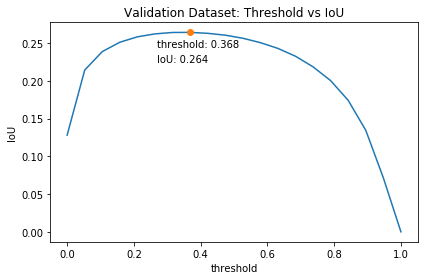

In [115]:
plt.plot(Ts, IOUs)
plt.plot(Ts[np.argmax(IOUs)], IOUs[np.argmax(IOUs)], 'o')
plt.text(Ts[np.argmax(IOUs)]-0.1, IOUs[np.argmax(IOUs)]-0.02, s = 'threshold: '+str(Ts[np.argmax(IOUs)])[0:5])
plt.text(Ts[np.argmax(IOUs)]-0.1, IOUs[np.argmax(IOUs)]-0.04, s = 'IoU: '+str(IOUs[np.argmax(IOUs)])[0:5])
plt.xlabel('threshold')
plt.ylabel('IoU')
plt.title('Validation Dataset: Threshold vs IoU')
plt.tight_layout()

## Evaluate Testing Dataset

In [112]:
best_t = 0.3684210526315789

In [114]:
iou_list = []
for i in range(len(new_IDs)//32 + 1):
    ids = new_IDs[i*32:(i+1)*32]
    Xs, Ms = batch_data_generation(ids)
    iou = calculate_IoU(Xs, Ms, best_t)
    iou_list.append(iou)
print('IoU: {:.3f}'.format(np.mean(iou_list)))

IoU: 0.268


## Prediction Visualization

In [154]:
def plot_true_pred_optimized(Xs, Ys, threshold=best_t, model = saved_model):
    clouds = np.array(['Fish', 'Flower', 'Gravel', 'Sugar'])
    idx = np.random.choice(np.arange(Xs.shape[0]))
    y_proba = model.predict(np.expand_dims(Xs[idx], 0)).squeeze()
    y_proba[y_proba > threshold] = 1.
    y_proba[y_proba <= threshold] = 0.
    
    # Calculate IoU
    '''IoU'''
    tp = Ys[idx]*y_proba
    tp = sum(tp[tp == 1])
    
    union = Ys[idx]+y_proba
    union = sum(union[union >= 1.])
    print('IoU: {:.3f}'.format(tp/union))
    
    plt.figure(figsize = (10, 5))
    plt.imshow(Xs[idx]); plt.title('Ori Img')
    plt.axis('off')
    plt.figure(figsize = (20, 10))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        plt.imshow(Ys[idx][:, :, i]);
        plt.title('Groud Truth: '+clouds[i], fontsize = 15)
        plt.axis('off')
    j = 5
    for i in range(4):
        plt.subplot(2, 4, j)
        plt.imshow(y_proba[:, :, i])
        plt.title('Predicted: '+clouds[i], fontsize = 15)
        plt.axis('off')
        j += 1
    plt.tight_layout()
    plt.show()

In [150]:
i = 5
ids = new_IDs[i*32:(i+1)*32]
Xs, Ms = batch_data_generation(ids)

IoU: 0.294


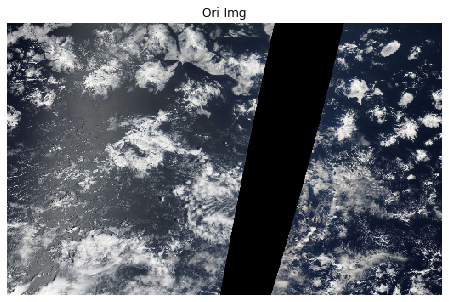

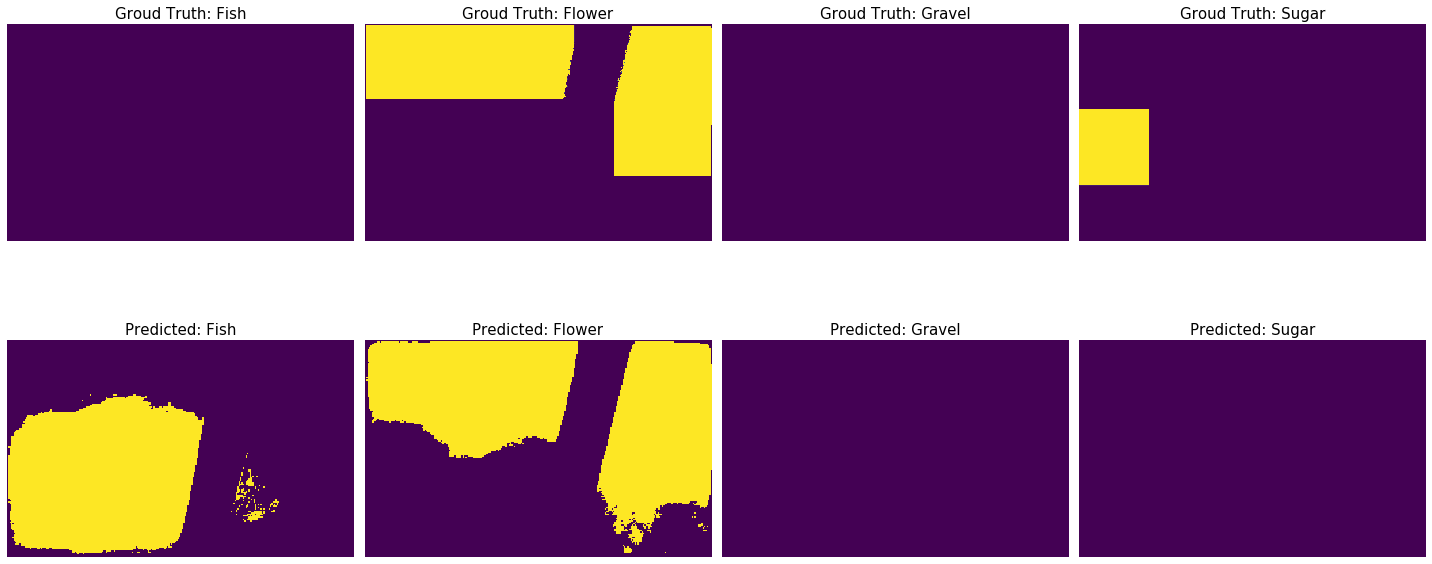

In [201]:
plot_true_pred_optimized(Xs, Ms)

IoU: 0.430


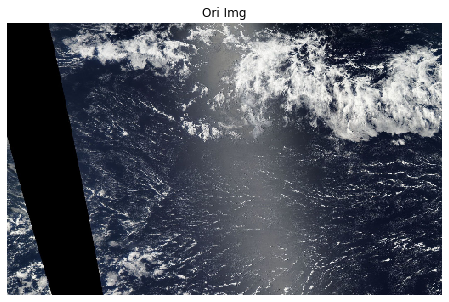

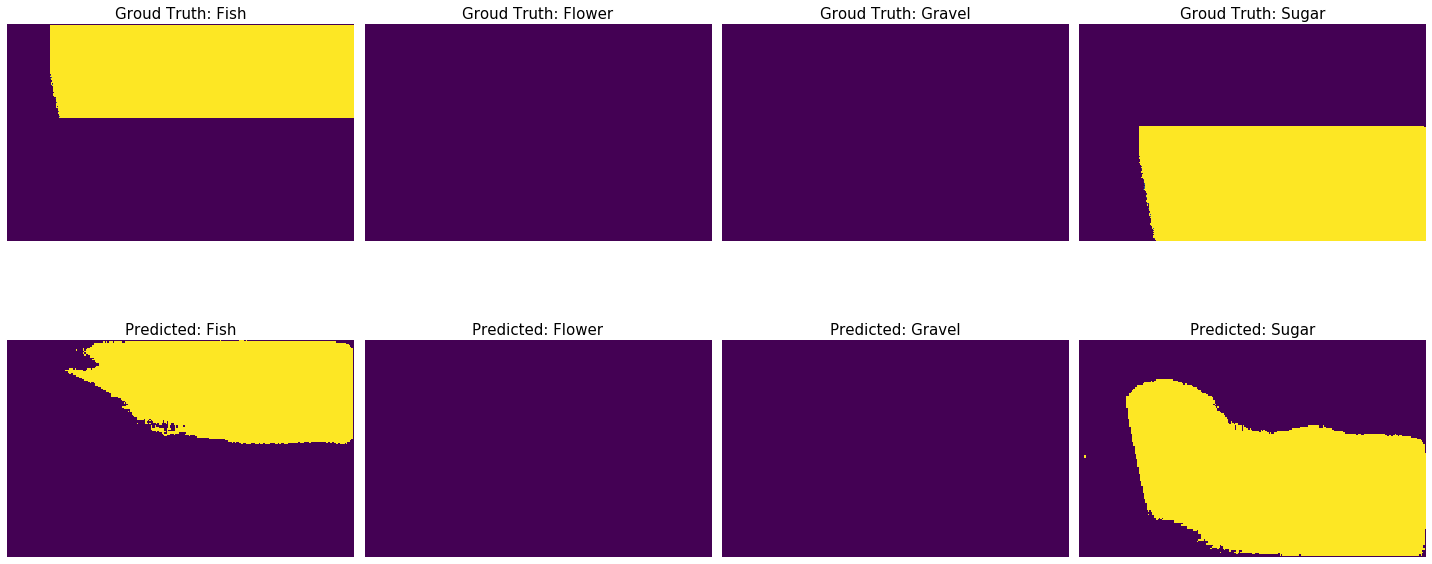

In [197]:
plot_true_pred_optimized(Xs, Ms)